# Phishing Detection Feature Engineering

This notebook will create, visualize and explain some of the thinking behind the feature engineering.

## Data Breakdown

The dataset used contains two columns:

URL - A string representing the url

Label - Yes or No representing a phishing or non-phishing case respectively.

The following graphic shows the different parts of a url, this will allow us to discuss the ways a Phisher can create URLs that attack victims.


![](images/Url_Parts.png)


| Part                	| Description                                                                                           	| Significance                                                                                                                                    	| Significance Rating 	|
|---------------------	|-------------------------------------------------------------------------------------------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------	|---------------------	|
| Protocol            	| The protocol used to access the webpage (https:// for secure and http:// for not)                     	| The protocol is decided by the developer, Phishers may be more likely to not use encryption                                                     	| little - none       	|
| domain name         	| A restricted part of the url as it must be registered                                                 	| This cannot be identical to existing domain names. However, small changes like PayPal.com -> paywall.com are commonly used                      	| High - Medium       	|
| second-level domain 	| The first part of the domain name                                                                     	| spelling of existing second-level domains that are being targeted can be slightly changed                                                       	| High - Medium       	|
| Top-level domain    	| The second part of the domain name                                                                    	| If PayPal doesn't own the .net domain name PayPal.net can be registered and used by Phishers                                                    	| Medium              	|
| sub-level domain  	| This can be freely changed. A legitimate use is Amazon.com could use checkout.amazon.com.             	| Phishers can trick victims into thinking subdomain name is the domain name. For example, PayPal.com.mywebsite.com (PayPal.com is the subdomain) 	| High                	|
| path                	| This can be freely changed. It represents a directory and possible file your accessing on the website 	| Can be used to inject legitimate company names or to run harmful scripts                                                                        	| High                	|

### Terminology
FreeURL - An unregistered portion of the url that can be freely altered by developers such as sub-level-domain

None - Is estimated to have no relevance in detecting a Phishing URL
Little - Is estimated to have some relevance in detecting a Phshing URL
Medium - Is estimated to have a significant impact to detecting a Phishing URL and development time is recommended.
High - Is estimated to have a high significant import to detecting a Phishing URL and developement time is required.

## Notebook Goals
- Create a new dataset of features for medium and high Significance Rating
- Provide visualtizations and basic analysis of the features to determine effectiveness (such as correlation matrix)
- Output this dataset to a .csv file for use in a model

In [1]:
# Loading common required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import tldextract # library that allows us to break down a url

# Load data
DATA_PATH = 'data/phishing_site_urls.csv'

data = pd.read_csv('data/phishing_site_urls.csv')

"""
This function is responsible for simple preprocessing for a url such as removing url's surrounded in quotes
"""
def preprocess_url(url):
    url = url.replace('http://', '').replace('https://', '')
    return url

data['URL'] = data['URL'].apply(preprocess_url)

print('Basic Statistics... ')
print('\nDataset dimensions:', data.shape)
print('Dataset columns:', data.columns)

count_data = data.groupby('Label').count()
count_data = count_data / count_data.sum()
print('Dataset Distribution:\n', count_data)

# Now map the label to numeric values
data['Label'] = data['Label'].map({'bad': 1, 'good': 0})

Basic Statistics... 

Dataset dimensions: (549346, 2)
Dataset columns: Index(['URL', 'Label'], dtype='object')
Dataset Distribution:
             URL
Label          
bad    0.284742
good   0.715258


# Url Processes Helpers
The following are functions capable of selecting the individual parts of a url. They will assist when investigating and extracting features

In [2]:
def extract(url):
    extraction_data = {}
    extraction = tldextract.extract(url)

    extraction_data['subdomain'] = extraction.subdomain
    extraction_data['domain'] = extraction.domain
    extraction_data['suffix'] = extraction.suffix
    extraction_data['domain_name'] = extraction.domain + "." + extraction.suffix

    path_regex = re.compile(r'(\w+://){,1}/((/|.)+)')
    try:
        path = path_regex.search(url).group(0)
        extraction_data['path'] = path
    except AttributeError:
        extraction_data['path'] = ''
    return extraction_data
    
    

# Simple Features

- Number of periods in the URL
  - Multiple subdomains are uncommon amongst legitimate urls.
- Number of slashes
  - Large numbers of slashes to direct you all to long routes is common for Phishing urls
- Length of the URL
  - Common url's have smaller lengths than most Phishing URLs
- Number of numbers in the URL
  - Phishing urls commonly contain numbers this is less common with legitimate urls
- firstdigit
  - Maybe Phishing websites start with digits more often

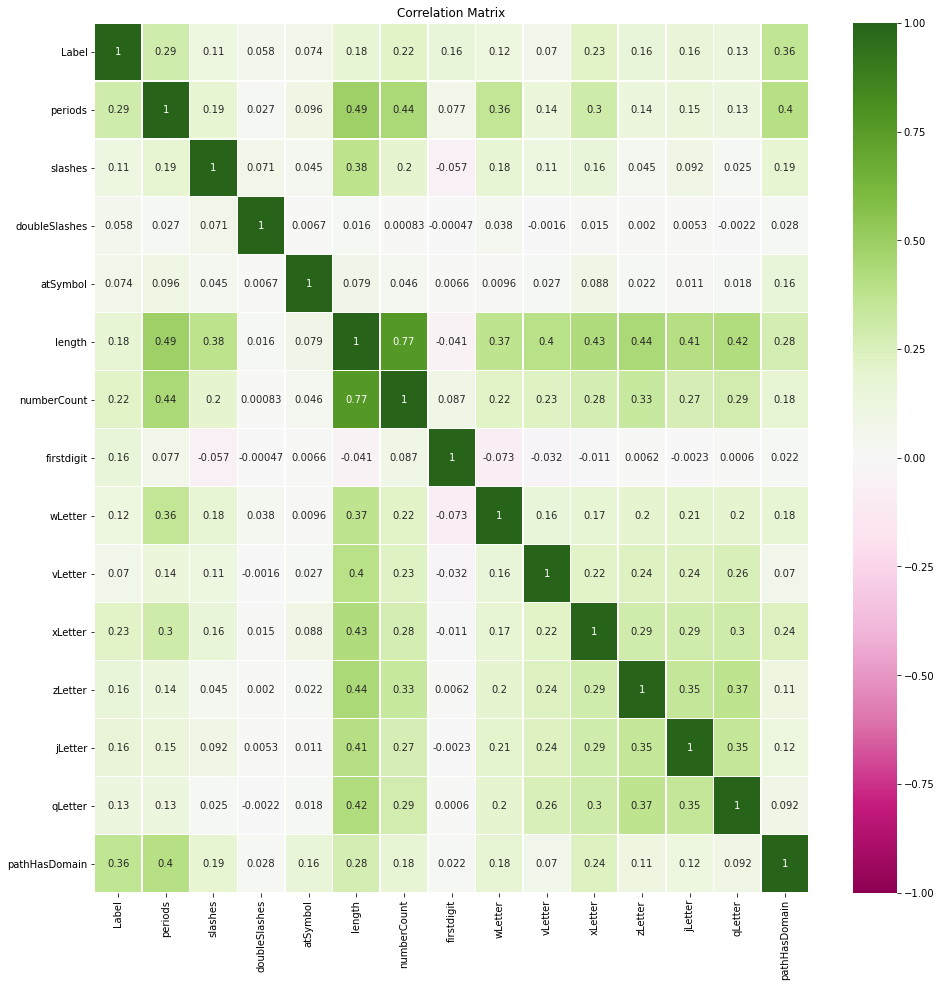

In [3]:
data['periods'] = data['URL'].apply(lambda url: url.count('.'))
data['slashes'] = data['URL'].apply(lambda url: url.count('/'))
data['doubleSlashes'] = data['URL'].apply(lambda url: url.count('//'))
data['atSymbol'] = data['URL'].apply(lambda url: url.count('@'))
data['length'] = data['URL'].apply(lambda url: len(url))
data['numberCount'] = data['URL'].apply(lambda url: sum(c.isdigit() for c in url))
data['firstdigit'] = data['URL'].apply(lambda url: int(url[0].isdigit()))

data['wLetter'] = data['URL'].apply(lambda url: url.count('w'))
data['vLetter'] = data['URL'].apply(lambda url: url.count('v'))
data['xLetter'] = data['URL'].apply(lambda url: url.count('x'))
data['zLetter'] = data['URL'].apply(lambda url: url.count('z'))
data['jLetter'] = data['URL'].apply(lambda url: url.count('j'))
data['qLetter'] = data['URL'].apply(lambda url: url.count('q'))

def substring_has_domain(substring):
    count = substring.count('.com')
    count += substring.count('.net')
    count += substring.count('.ca')
    count += substring.count('.php')
    count += substring.count('.www')
    return count

data['pathHasDomain'] = data['URL'].apply(lambda url: substring_has_domain(extract(url)['path']))

plt.subplots(figsize=(len(data.columns), len(data.columns)))
sns.heatmap(data.corr(), annot=True, center=0, cmap='PiYG', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# More Advanced and Creative Features
These are features that contain more advanced concepts such as IP addresses or URL domains.

- Contains an IP address
- Number of semicolons
  - Websites can pass information using the pattern ?variable=value;variable2=value2
- Number of domains such of .com, .ca and .net
  - Phishing websites commonly contain many domains

In [4]:
data['IP'] = data['URL'].apply(lambda url: int(re.search('(?:\d{1,3}\.){3}\d{1,3}', url) is not None))
data['semicolon'] = data['URL'].apply(lambda url: url.count(';'))

domains = ['.com', '.net', '.ca', '.html', '.exe', '.xyz', '.php', '.rar']
data["domain"] = data['URL'].apply(lambda url: sum(substring in url for substring in domains))

vowelLetter = ['a', 'e', 'i', 'o', 'u']
data['vowels'] = data['URL'].apply(lambda url: sum(letter in vowelLetter for letter in url))
data['dotService'] = data['URL'].apply(lambda url: url.count('.edu') + url.count('.org'))

data["hash"] = data['URL'].apply(lambda url: int(re.search('[0-9a-f]{64}|[0-9a-f]{32}', url) is not None))
print(data)

                                                      URL  Label  periods  \
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...      1        6   
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      1        5   
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....      1        7   
3       mail.printakid.com/www.online.americanexpress....      1        6   
4       thewhiskeydregs.com/wp-content/themes/widescre...      1        1   
...                                                   ...    ...      ...   
549341                                    23.227.196.215/      1        3   
549342                                 apple-checker.org/      1        1   
549343                                  apple-iclods.org/      1        1   
549344                                 apple-uptoday.org/      1        1   
549345                                  apple-search.info      1        1   

        slashes  doubleSlashes  atSymbol  length  numberCount  firstdigit  

# Correlation Matrix
Show how these features well these features correlate to the Label

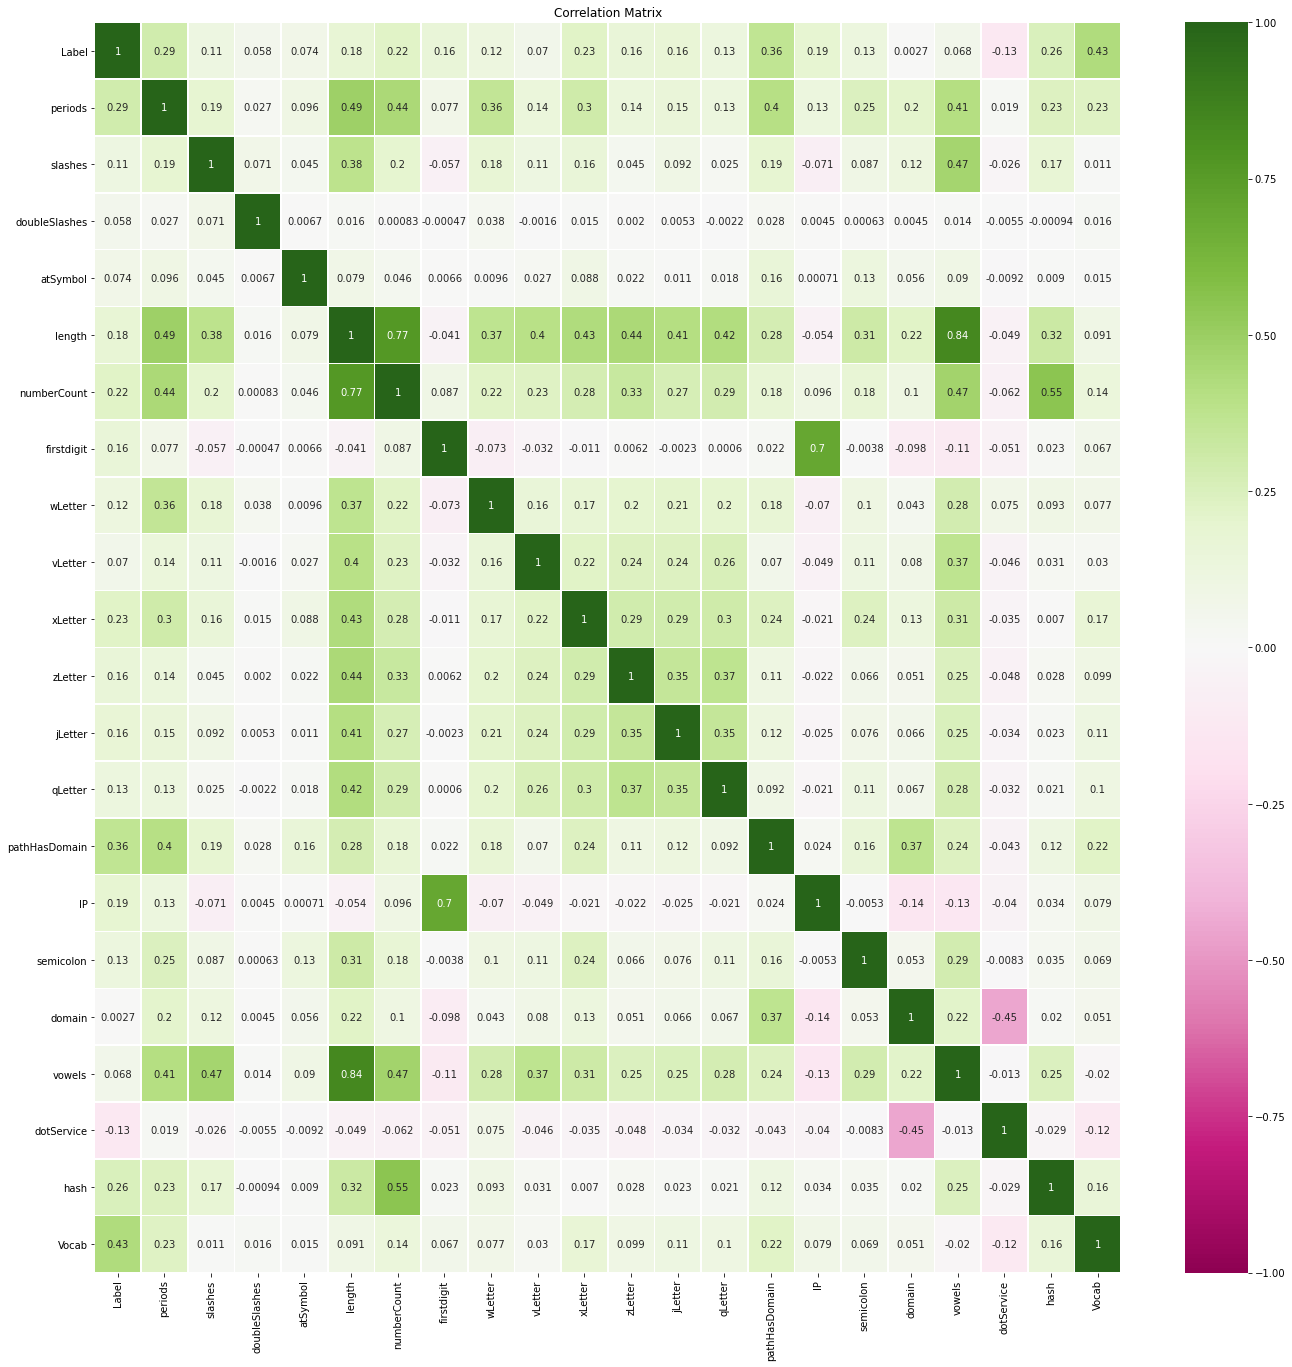

In [5]:
links = pd.read_csv("data/commonString.csv") 
commonWord = links['String']
g1 = links['Good']
t1 = links['Word Count']
def VocabCheck(url):
    # define variables
    goodWordsFound = 0
    badWordsFound = 0
    
    # Run through the list of common words
    for i in range (0,len(commonWord),1):
        if url.find(commonWord[i]) >= 0:
            # if found state whether word is good or bad
            if g1[i] > t1[i] - g1[i]:
                goodWordsFound += 1
            else:
                badWordsFound += 1

    #Determine the final result
    if badWordsFound > 0 and goodWordsFound > 0:
        return 0
    elif goodWordsFound > 0:
        return -1
    elif badWordsFound > 0:
        return 1
    else:
        return 0

data['Vocab'] = data['URL'].apply(VocabCheck)


plt.subplots(figsize=(len(data.columns), len(data.columns)))
sns.heatmap(data.corr(), annot=True, center=0, cmap='PiYG', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [6]:
data = data.drop('URL', axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.to_csv('data/data_featured.csv')